Ranks:
All Rankings:  [807, 1761, 351, 191, 671, 15238, 318, 66, 2379, 973, 4056, 14465, 6, 2082, 2214, 161281, 832, 1317, 77, 147304, 543, 94214, 188, 6947, 1607, 2087, 7614, 408, 1247, 296, 7374, 1451, 2380, 1118, 78, 11, 534, 2263, 222, 1308, 3130, 1174, 428, 3587, 115, 645, 5049, 280, 105, 1280, 1130, 545, 99943, 3411, 141, 795, 40, 2046, 1457, 3399, 4060, 814, 5, 51, 4, 5133, 5606, 130, 273, 392, 68149, 258, 563, 266, 625, 839, 1366, 2117, 3797, 5033, 144, 145, 4786, 1992, 6604, 3842, 675, 701, 872, 735, 440, 7306, 139935, 532, 180, 367, 46, 11, 724, 970]
Mean of Rankings:  8874.67
Stdev:  28972.567900017075


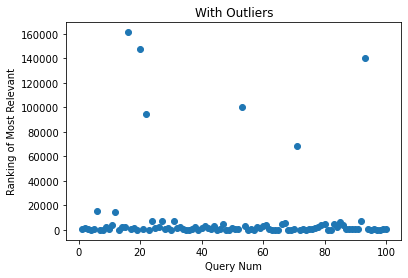

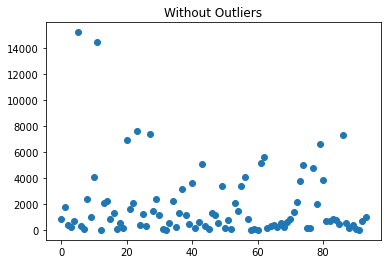

MRR SCORE: 0.01055911777205951
Nums under 1000:  53
Nums under 20000:  94
PRECISION: 0.0


In [6]:
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
import warnings
import json
import string
from nltk.stem import PorterStemmer
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import re
import nltk
import sys
import collections
import math
import argparse
import getpass
import os
import pickle

#os.environ["OPENAI_API_KEY"] = getpass.getpass()
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


def remove_stop_words(input):
    return " ".join([w for w in input.split() if w not in stop_word_array ])

def lower_text(input):
    new_input = input.lower()
    return new_input

def remove_puncutation(input):
    mapping = str.maketrans("", "" , string.punctuation);       # creates a mapping to remove punctuatation
    return input.translate(mapping)

def remove_numbers(input):
    return re.sub(r'[0-9]', '', input)

def stem_str(input):
    port = PorterStemmer()
    split_input = word_tokenize(input)
    for i in range(len(split_input)):
        split_input[i] = port.stem(split_input[i])
    return " ".join(split_input)

def lemma_str(input):
    lemma = WordNetLemmatizer()
    split_input = word_tokenize(input)
    for i in range(len(split_input)):
        split_input[i] = lemma.lemmatize(split_input[i])
    return " ".join(split_input)

def remove_other_words(input):
    return " ".join([w for w in input.split() if w not in other_array ])

def run_query(docs_dicts, query_str, id_to_article_dict):
    # Use ltn to weight terms in the query:
    #   l: logarithmic tf
    #   t: idf
    #   n: no normalization


    # Return the top-10 document for the query 'terms'
    term_dict = collections.defaultdict(lambda: [])
    terms = query_str.lower().split()
    
    for token in terms:
        if token not in term_dict:
            term_dict[token] = 1
        else:
            term_dict[token] += 1
            
    for key in term_dict:           # for every key we want to find its log weight, idf, and total weight
        log_weight = 1 + math.log(term_dict[key], 10)
        
        document_frequency = 0          # we obtain the df for every unqiue term in the query
        for cur_dict in docs_dicts:
            if key in cur_dict:
                document_frequency += 1
                
        idf = 0
        
        if (document_frequency == 0):
            idf = 0
        else:
            idf = len(docs_dicts)/document_frequency
            idf = math.log(idf, 10)
        
        weight = log_weight * idf
        term_dict[key] = weight
        
    # Get all similarity scores between query and all docs
    scores = []
    index = 0
    
    for cur_dict in docs_dicts:
        score = 0
        for key in term_dict:
            if key in cur_dict:
                score += cur_dict[key] * term_dict[key]
        cur_item = [score, index]
        scores.append(cur_item)
        index += 1
        
    # scores contains list of [score, index] sorted from max score to min score
    scores.sort(key=lambda sublist: sublist[0], reverse=True)

    return scores

# PREPROCESSING

# Step 1: Get a collection of documents, each document contains terms

id_to_title_dict = {}
doc_tokens = []

f = open('stop_words_english.json')
stop_word_array = json.load(f)

other_array = ['refer', 'link', "file", "url"]
all_files = os.listdir()
wiki_files = [f for f in all_files if f.startswith("enwiki-20140602-pages-articles.xml")]

cur_id = 0
cur_str = ""


for file in wiki_files:     # first apply the preprocessing!!!!
    f = open(file, 'r')
    
    for line in f:
        # We are getting the title of the a page. (Also indicates we reached the next page.)
        cur_terms = line.split()
        if ( (len(line) >= 5) and (line[:2] == "[[") and (line[(len(line) -3):(len(line) -1)] == "]]") and ("File:" not in line)):
            
            title = line[2: (len(line) -3)]
            id_to_title_dict[cur_id] = title

            if (cur_str != ""):
                temp = cur_str.replace("\n", " ")
                doc_tokens.append(temp)
                
            cur_id += 1
            cur_str = (title + " ")
        elif (len(line) >= 3) and (line[0] == "=") and (line[-2] == "="):
            continue
        elif ( (len(cur_terms) >= 3) and (cur_terms[0] == "|") and (cur_terms[2] == "=")):
            continue
        else:
            if line != "\n":
                cur_str += line


preprocess = input("Preprocess: ")
term_strings = []

if (preprocess == "yyyy"):
    data = pd.DataFrame(doc_tokens, columns=['text'])
    data["text"] = data["text"].apply(remove_puncutation)
    data["text"] = data["text"].apply(lower_text)
    data["text"] = data["text"].apply(remove_stop_words)
    data["text"] = data["text"].apply(remove_other_words)               
    data["text"] = data["text"].apply(stem_str)               
    data["text"] = data["text"].apply(lemma_str)

    term_strings = data["text"].to_numpy()

    result_file = open('results.txt', 'w')
    for terms_string in term_strings:
        result_file.write(terms_string + '\n')
    result_file.close()
else: 
    read_file = open('results.txt', 'r')
    for line in read_file:
        temp = line.rstrip('\n')
        term_strings.append(temp)

# Step 2: Get a list of processed queries and answers
f = open("questions.txt", 'r')
answers = []
queries = []

counter = 0
cur_str = ""

for line in f:
    if line == "\n":
        continue
    if (counter == 2):
        temp_one = line.replace("\n", "")
        answers.append(temp_one)
        
        temp_two = cur_str.replace("\n", " ")
        queries.append(temp_two)
        
        counter = 0
        cur_str = ""
    else:
        cur_str += line
        counter +=1
        

query_data =  pd.DataFrame(queries, columns=['text'])
query_data["text"] = query_data["text"].apply(remove_puncutation)
query_data["text"] = query_data["text"].apply(lower_text)
query_data["text"] = query_data["text"].apply(remove_stop_words)
query_data["text"] = query_data["text"].apply(remove_other_words)
query_data["text"] = query_data["text"].apply(stem_str)               
query_data["text"] = query_data["text"].apply(lemma_str)

final_query_data = query_data["text"].to_numpy()

# RANK RESULTS VIA TF-IDF
scores_index_per_query = []     # each query has a list, list has elements of type [score, id]

store_tfidf = input("Store: ")

if (store_tfidf == "store"):
    # Use lnc to weight terms in the documents:
    #   l: logarithmic tf
    #   n: no df
    #   c: cosine normalization
    dict_list = []      # used for document part of scoring
    
    for cur_string in term_strings:
        
        tokens = cur_string.split()   
        # list of tokens
        cur_dict = collections.defaultdict(lambda: [])

        for token in tokens:
            if token not in cur_dict:
                cur_dict[token] = 1
            else:
                cur_dict[token] += 1
                
        # we obtain the logramthic term frequency of each term in the current document
        cur_total_weight = 0
        for key in cur_dict:
            log_weight = 1 + math.log(cur_dict[key], 10)
            cur_total_weight += (log_weight ** 2)
            cur_dict[key] = log_weight
            
        # every log frequency will be divided by this to obtain the normalized document frequency
        cur_total_weight = math.sqrt(cur_total_weight)
        
        for key in cur_dict:
            cur_dict[key] = cur_dict[key]/cur_total_weight
            
        dict_list.append(cur_dict)


    for query in final_query_data:
        cur_top_ten = run_query(dict_list, query, id_to_title_dict)
        scores_index_per_query.append(cur_top_ten)
        

    with open('scores_index_per_query.pickle', "wb") as file:
        pickle.dump(scores_index_per_query, file)
else:
    with open('scores_index_per_query.pickle', "rb") as file:
        scores_index_per_query = pickle.load(file)



all_terms_ranked_list = []

# RERANK TOP X RESULTS VIA PROMPTING (didn't work out)
'''
num = 5
for idx, scores_index in enumerate(scores_index_per_query):
    temp_scores_index = scores_index[:num]        # we want to reorder top 100 elements

    cur_docs = []
    for i in range(len(temp_scores_index)):
        cur_index = temp_scores_index[i][1]
        cur_text = term_strings[cur_index]
        
        cur_doc = Document(page_content=cur_text, metadata={})
        cur_doc.metadata["id"] = cur_index
        cur_docs.append(cur_doc)

    
    embedding = OpenAIEmbeddings(model="text-embedding-ada-002", )
    retriever = FAISS.from_documents(cur_docs, embedding).as_retriever(search_kwargs={"k": num})

    cur_query = final_query_data[idx]
    

    llm = ChatOpenAI(temperature=0)
    compressor = FlashrankRerank()
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )

    compressed_docs = compression_retriever.invoke(
        cur_query
    )
    cur_terms_ranked_list = []
    cur_LLM_reranks = [doc.metadata["id"] for doc in compressed_docs]
    
    for id in cur_LLM_reranks:
        cur_title = id_to_title_dict[id]
        cur_terms_ranked_list.append(cur_title)

    for score in scores_index[num:]:
        cur_index = score[1]
        cur_title = id_to_title_dict[cur_index]
        cur_terms_ranked_list.append(cur_title)
        
    all_terms_ranked_list.append(cur_terms_ranked_list)
'''

for idx, scores_index in enumerate(scores_index_per_query):
    cur_terms_ranked_list = []
    for score in scores_index:
        
        cur_index = score[1]            # contains the doc id
        cur_title = id_to_title_dict[cur_index]
        cur_terms_ranked_list.append(cur_title)
            
    all_terms_ranked_list.append(cur_terms_ranked_list)

MRR_Score = 0

print("Ranks:")
all_rankings = []
for i in range(len(all_terms_ranked_list)):        
    
    prediction = all_terms_ranked_list[i]          
    str_of_answer = answers[i]
    cur_rank = 0
    if ("|" in str_of_answer):
        two_answers = str_of_answer.split("|")
        first_rank = len(prediction) + 1 
        second_rank = len(prediction) + 1 
        
        if (two_answers[0] in prediction):
            first_rank = (prediction.index(two_answers[0])) + 1
        if (two_answers[1] in prediction):
            second_rank = (prediction.index(two_answers[1])) + 1
        
        both_ranks = [first_rank, second_rank]
        cur_rank = min(both_ranks)
    
    else:
        cur_rank = (prediction.index(str_of_answer)) + 1
        
    all_rankings.append(cur_rank)
    MRR_Score += (1/cur_rank)
    
mean_of_rankings = np.mean(all_rankings)
print("All Rankings: ", all_rankings)
print("Mean of Rankings: ", mean_of_rankings)


stdev = 0
for cur_item in all_rankings:
    cur_element = (cur_item - mean_of_rankings)**2
    stdev += cur_element
stdev = stdev/len(all_rankings)
stdev = math.sqrt(stdev)

print("Stdev: ", stdev)

index_list = list(range(1,101))
plt.xlabel("Query Num")
plt.ylabel("Ranking of Most Relevant")
plt.scatter(index_list, all_rankings)
plt.title("With Outliers")
plt.show()

new_list = []
for cur_item in all_rankings:
    if (cur_item < 20000):
        new_list.append(cur_item)
        
index_list_two = list(range(len(new_list)))
plt.title("Without Outliers")
plt.scatter(index_list_two, new_list)
plt.show()


MRR_Score = (MRR_Score)/(len(answers))
print("MRR SCORE:", MRR_Score)

counter = 0
counter_two = 0
for cur_item in all_rankings:
    if(cur_item < 1000):
        counter += 1

    if(cur_item < 20000):
        counter_two += 1
        

print("Nums under 1000: ", counter)
print("Nums under 20000: ", counter_two)

precision_at_1 = 0
for i in range(len(all_terms_ranked_list)):
    cur_rank_one = all_terms_ranked_list[i][0]
    if cur_rank_one == answers[i]:
        precision_at_1 += 1
precision_at_1 = precision_at_1/len(answers)
print("PRECISION:", precision_at_1)




